In [322]:
import os
import sys
sys.path.append('./src') 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import yaml

from datasets import build_dataset, build_transforms
from denoiser import get_denoiser
from models import create_vae

import matplotlib.pyplot as plt 
import numpy as np
from tqdm import tqdm

from backbones import get_backbone
from denoiser import get_denoiser, Denoiser

In [1306]:
dataset = "mvtec_ad"
category = "metal_nut"
num_inference_steps = 2
device = 'cuda'
num_samples = 1
start_step = 64

In [1307]:
from torch.utils.data import DataLoader
import torch

img_size = 256

normal_dataset = build_dataset(
    dataset_name=dataset,
    data_root = f"data/{dataset}",
    train=False,
    img_size=img_size,
    transform_type="default",
    category = category,
    normal_only = True
)
anom_dataset = build_dataset(
    dataset_name=dataset,
    data_root = f"data/{dataset}",
    train=False,
    img_size=img_size,
    transform_type="default",
    category = category,
    anom_only = True
)
train_dataset = build_dataset(
    dataset_name=dataset,
    data_root = f"data/{dataset}",
    train=True,
    img_size=img_size,
    transform_type="default",
    category = category,
)
print(len(normal_dataset))
print(len(anom_dataset))

22
93


In [1308]:
# log_dir = f"./results/ad_unet_vae_ddad/{category}"
# log_dir = f"./results/exp_unet_feature_visa/{category}"
# log_dir = f"./results/exp_unet_feature_ad_256/{category}"

# log_dir = f"./results/exp_unet_feature_ad_es/{category}"
# log_dir = f"./results/exp_unet_feature_ad_512/{category}"
# log_dir = f"./results/exp_unet_feature_ad_wrn/{category}"

# log_dir = f"./results/w2d256ep1000"
# log_dir = f"./results/exp_dit_feature_d4w256_lr/{category}"
# log_dir = f"/home/haselab/projects/sakai/AnoMAR/AnoMAR/results/exp_unet_feature_visa_pdn/{category}"
log_dir = f"./results/exp_unet_feature_ad_best/{category}"
config_path = os.path.join(log_dir, "config.yaml")
ckpt_path = os.path.join(log_dir, "model_best_394.pth")

with open(config_path, 'r') as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

seed = config['meta']['seed']
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed) 

config["diffusion"]["num_sampling_steps"] = str(num_inference_steps)
img_size = config['data']['img_size']
device = device
num_samples = num_samples

mim_in_sh = (272, 16, 16) # for enet
# mim_in_sh = (1792, 16, 16)  # for wrn
# mim_in_sh = (384, 28, 28) # for pdn

img_size = config['data']['img_size']
model: Denoiser = get_denoiser(**config['diffusion'], input_shape=mim_in_sh)
model_ckpt = torch.load(ckpt_path, map_location='cpu', weights_only=True)
results = model.load_state_dict(model_ckpt, strict=False)
print(results)
model.to(device).eval()

def init_denoiser(num_inference_steps, device, config, in_sh, ckpt_path):
    config["diffusion"]["num_sampling_steps"] = str(num_inference_steps)
    model: Denoiser = get_denoiser(**config['diffusion'], input_shape=in_sh)
    model_ckpt = torch.load(ckpt_path, map_location='cpu', weights_only=True)
    results = model.load_state_dict(model_ckpt, strict=False)
    model.to(device).eval()
    return model

<All keys matched successfully>


In [ ]:
# model_kwargs = {
#     'model_type': 'efficientnet-b4',
#     'outblocks': (1, 5, 9, 21),
#     'outstrides': (2, 4, 8, 16),
#     'pretrained': True,
#     'stride': 16
# }
# # model_kwargs = {
# #     'model_type': 'wide_resnet50_2',
# # }
# # model_kwargs = {
# #     'model_type': 'pdn_medium',
# # }
# print(f"Using feature space reconstruction with {model_kwargs['model_type']} backbone")
# feature_extractor = get_backbone(**model_kwargs)
# feature_extractor.to(device).eval()

: 

In [1309]:
bs = 8
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4, drop_last=False)
normal_dataloader = DataLoader(normal_dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=False)
anom_dataloader = DataLoader(anom_dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=False)

start_t = torch.tensor([0] * bs, device=device, dtype=torch.long)
end_t = torch.tensor([num_inference_steps] * bs, device=device, dtype=torch.long)

In [1310]:
# Compute global stats for training data
features = []
for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
    img = data["samples"].to(device)
    with torch.no_grad():
        x, x_list = feature_extractor(img)
        # x = feature_extractor(img)
        features.append(x)
features = torch.cat(features, dim=0)   # (N, c, h, w)
avg_glo = features.mean(dim=(0, 2, 3))  # (c, )
std_glo = features.std(dim=(0, 2, 3))  # (c, )

100%|██████████| 28/28 [00:02<00:00, 10.73it/s]


In [ ]:
avg_glo.mean(), std_glo.mean()

(tensor(-0.0081, device='cuda:0'), tensor(4.1319, device='cuda:0'))

: 

In [8]:
def ddim_reverse_sample(
    model,
    x_t, 
    t, 
    cls_labels,
):
    model_kwargs = dict(c=cls_labels)
    sample_fn = model.net.forward
    
    indices = list(range(t[0].item(), int(model.num_sampling_steps)))
    intermediate_samples = []
    for i in indices:
        t = torch.tensor([i] * x_t.shape[0]).to(x_t.device)
        out = model.sample_diffusion.ddim_reverse_sample(
            sample_fn,
            x_t,
            t,
            clip_denoised=False,
            model_kwargs=model_kwargs,
            eta=0.0
        )
        x_t = out["sample"]
        intermediate_samples.append(x_t)
    return x_t, intermediate_samples

In [13]:
def get_last_latents(
    dataloader, 
    model,
    feature_extractor,
    avg_glo,
    std_glo,
    start_t,
):
    last_latents = []
    for i, data in enumerate(dataloader):
        img = data["samples"].to(device)
        labels = data["clslabels"].to(device)
        with torch.no_grad():
            x, _ = feature_extractor(img)
            x = (x - avg_glo[None, :, None, None]) / (std_glo[None, :, None, None] + 1e-6)
            x_t, _ = ddim_reverse_sample(model, x, start_t, labels)
            last_latents.append(x_t)
    return torch.cat(last_latents, dim=0)

def calculate_log_pdf(x):
    ll = -0.5 * (x ** 2 + np.log(2 * np.pi))
    ll = ll.sum(dim=(1, 2, 3))
    return ll

In [167]:
num_inference_steps = 2
model = init_denoiser(num_inference_steps, device, config, mim_in_sh, ckpt_path)

In [168]:
def calculate_log_pdf(x):
    ll = -0.5 * (x ** 2 + np.log(2 * np.pi))
    ll = ll.sum(dim=(1, 2, 3))
    return ll

def calculate_log_pdf_spatial(x):
    ll = -0.5 * (x ** 2 + np.log(2 * np.pi))
    ll = ll.sum(dim=1)
    return ll  # (N, h, w)

import time

normal_lls = []
lts = []
for batch in tqdm(normal_dataloader):
    images = batch["samples"].to(device)
    labels = batch["clslabels"].to(device)
    
    s_t = time.perf_counter()
    with torch.no_grad():
        # latents_org, _ = feature_extractor(images)
        latents_org = feature_extractor(images)
        latents_org = (latents_org - avg_glo.view(1, -1, 1, 1)) / (std_glo.view(1, -1, 1, 1) + 1e-6)
        # TODO: 
        # labels = None
        latents_last  = model.ddim_reverse_sample(
            latents_org, 
            start_t, 
            labels,
            eta=0.0
        )
        # latents_last = latents_org
    e_t = time.perf_counter()
    lts.append(e_t - s_t)
    ll = calculate_log_pdf(latents_last.cpu())
    normal_lls.extend(ll)

print(f"Average Latency: {np.mean(lts)}[s] for batch size {bs}")

100%|██████████| 13/13 [00:03<00:00,  4.00it/s]

Average Latency: 0.11600105167151643[s] for batch size 8


In [169]:
anom_lls = []
for batch in tqdm(anom_dataloader):
    images = batch["samples"].to(device)
    labels = batch["clslabels"].to(device)
    
    with torch.no_grad():
        # latents_org, _ = feature_extractor(images)
        latents_org = feature_extractor(images)
        latents_org = (latents_org - avg_glo.view(1, -1, 1, 1)) / (std_glo.view(1, -1, 1, 1) + 1e-6)
        # TODO: 
        # labels = None  # For previous model
        latents_last = model.ddim_reverse_sample(
            latents_org, start_t, labels, eta=0.0
        )
        # latents_last = latents_org
    
    ll = calculate_log_pdf(latents_last.cpu())
    anom_lls.extend(ll)

100%|██████████| 13/13 [00:03<00:00,  4.00it/s]


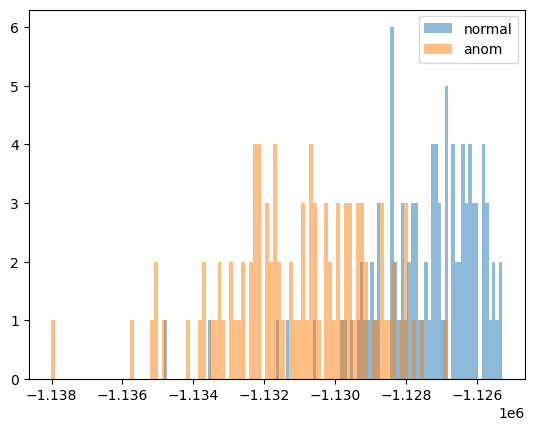

In [170]:
plt.hist(normal_lls, bins=100, alpha=0.5, label="normal")
plt.hist(anom_lls, bins=100, alpha=0.5, label="anom")
plt.legend()
plt.show()

In [171]:
from sklearn.metrics import roc_curve, roc_auc_score
normal_lls = np.array(normal_lls) * -1
anom_lls = np.array(anom_lls) * -1
y_true = np.concatenate([np.zeros(len(normal_lls)), np.ones(len(anom_lls))])
y_score = np.concatenate([normal_lls, anom_lls])
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = roc_auc_score(y_true, y_score)

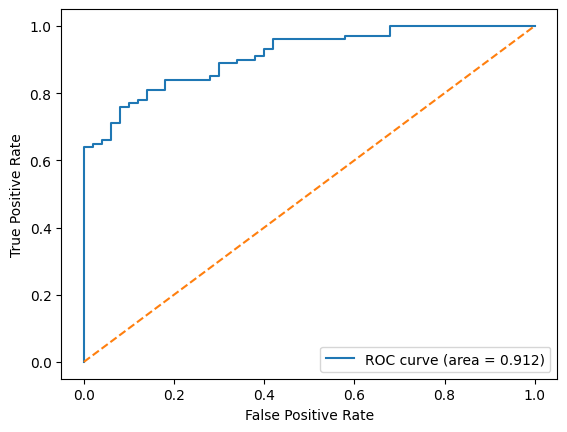

In [90]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.3f})")
ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
plt.show()

In [719]:
steps_list = [2, 3, 4, 5, 8, 11, 15, 20, 25, 30]

results_dict = {s: {'n': [], 'a': [], 't': []} for s in steps_list}
for s in tqdm(steps_list):
    model = init_denoiser(s, device, config, mim_in_sh, ckpt_path)
    x_ts_t = get_last_latents(train_loader, model, feature_extractor, avg_glo, std_glo, start_t)
    x_ts_n = get_last_latents(normal_dataloader, model, feature_extractor, avg_glo, std_glo, start_t)
    x_ts_a = get_last_latents(anom_dataloader, model, feature_extractor, avg_glo, std_glo, start_t)
    results_dict[s]['t'] = x_ts_t
    results_dict[s]['n'] = x_ts_n
    results_dict[s]['a'] = x_ts_a

  0%|          | 0/10 [00:03<?, ?it/s]


KeyboardInterrupt: 

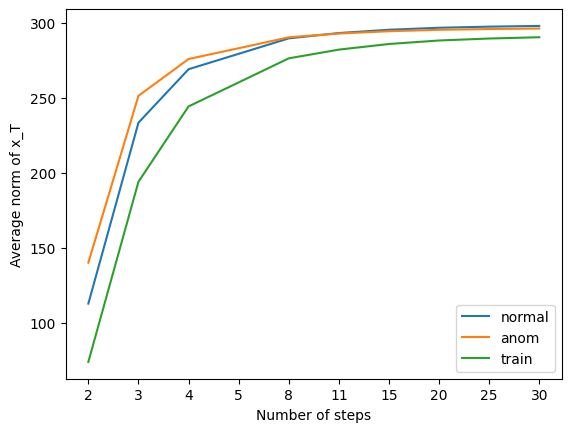

In [ ]:
# Plot average norm of each x_T for all steps
avg_norms = {s: {'n': 0, 'a': 0, 't': 0} for s in steps_list}
for s in steps_list:
    x_ts_n = results_dict[s]['n']
    x_ts_a = results_dict[s]['a']
    x_ts_t = results_dict[s]['t']
    avg_norms[s]['n'] = torch.sum(x_ts_n ** 2, dim=(1, 2, 3)).mean().sqrt().item()
    avg_norms[s]['a'] = torch.sum(x_ts_a ** 2, dim=(1, 2, 3)).mean().sqrt().item()
    avg_norms[s]['t'] = torch.sum(x_ts_t ** 2, dim=(1, 2, 3)).mean().sqrt().item()
    
# Plot average norm of each x_T for all steps
# y_dim: average norm of x_T
# x_dim: number of steps

plt.plot([avg_norms[s]['n'] for s in steps_list], label="normal")
plt.plot([avg_norms[s]['a'] for s in steps_list], label="anom")
plt.plot([avg_norms[s]['t'] for s in steps_list], label="train")
plt.xticks(range(len(steps_list)), steps_list)
plt.xlabel("Number of steps")
plt.ylabel("Average norm of x_T")
plt.legend()
plt.show()

In [ ]:
avg_norms

{2: {'n': 112.79133605957031, 'a': 140.08746337890625, 't': 73.95531463623047},
 3: {'n': 233.31375122070312,
  'a': 251.20481872558594,
  't': 193.95533752441406},
 4: {'n': 268.9453430175781, 'a': 275.7479553222656, 't': 244.17173767089844},
 5: {'n': 279.2037658691406, 'a': 282.9316711425781, 't': 260.14764404296875},
 8: {'n': 289.4996337890625, 'a': 290.2095947265625, 't': 276.2005615234375},
 11: {'n': 293.05126953125, 'a': 292.7216491699219, 't': 282.00341796875},
 15: {'n': 295.23760986328125, 'a': 294.2610168457031, 't': 285.7522277832031},
 20: {'n': 296.5745849609375, 'a': 295.2013244628906, 't': 288.0845031738281},
 25: {'n': 297.3114318847656, 'a': 295.7187194824219, 't': 289.4070739746094},
 30: {'n': 297.7944030761719, 'a': 296.06427001953125, 't': 290.2554626464844}}

### Typicality Test in Latent Space (TTL)

In [1281]:
num_dims = mim_in_sh[0] # * mim_in_sh[1] * mim_in_sh[2]

start_idx = 0
# start_t = torch.tensor([start_t] * bs, device=device, dtype=torch.long)
num_dims = 0# mim_in_sh[0]

In [1282]:
def calculate_log_pdf(x):
    ll = -0.5 * (x ** 2 + np.log(2 * np.pi))
    ll = ll.sum(dim=(1, 2, 3))
    return ll

def calculate_log_pdf_spatial(x):
    ll = -0.5 * (x ** 2 + np.log(2 * np.pi))
    ll = ll.sum(dim=1)
    return ll  # (N, h, w)

In [1322]:
num_inference_steps = 3
model = init_denoiser(num_inference_steps, device, config, mim_in_sh, ckpt_path)

normal_ats = []
normal_nlls = []
lts = []

normal_ats_sp = []
normal_nlls_sp = []

normal_gt_masks = []

import time
for batch in tqdm(normal_dataloader):
    images = batch["samples"].to(device)
    labels = batch["clslabels"].to(device)
    gt_mask = batch["masks"].to(device)
    normal_gt_masks.append(gt_mask)
    
    s_t = time.time()
    with torch.no_grad():
        latents_org, _ = feature_extractor(images)
        # latents_org = feature_extractor(images)
        latents_org = (latents_org - avg_glo.view(1, -1, 1, 1)) / (std_glo.view(1, -1, 1, 1) + 1e-6)
        # TODO:
        start_t = torch.tensor([start_idx] * len(images), device=device, dtype=torch.long)
        if start_idx > 0:
            latents_org = model.q_sample(
                latents_org,
                start_t,
            )
        # labels = None
        latents_last = model.ddim_reverse_sample(
            latents_org, start_t, labels, eta=0.0
        )
        # latents_last = latents_org
    e_t = time.time()
    lts.append(e_t - s_t)
    latents_last_l2 = torch.sum(latents_last ** 2, dim=1).sqrt()  # (bs, h, w)
    ats = torch.abs(latents_last_l2 - torch.sqrt(torch.tensor([num_dims], device=device, dtype=torch.float32)))  # (bs, h, w)
    min_ats_spatial = ats.view(ats.shape[0], -1).min(dim=1)[0]  # (bs, )
    max_ats_spatial = ats.view(ats.shape[0], -1).max(dim=1)[0]  # (bs, )
    ats = torch.abs(min_ats_spatial - max_ats_spatial)  # (bs, )
    nll = calculate_log_pdf(latents_last.cpu()) * -1
    nll_sp = calculate_log_pdf_spatial(latents_last.cpu()) * -1
    ats_sp = torch.abs(latents_last_l2 - min_ats_spatial[:, None, None])  # (bs, h, w)
    
    normal_nlls.extend(nll)
    normal_nlls_sp.extend(nll_sp)
    normal_ats_sp.extend(ats_sp.cpu())
    # ats = torch.std(ats.view(ats.shape[0], -1), dim=1)
    # ats = ats.mean(dim=(1, 2))
    
    normal_ats.extend(ats.cpu().numpy())
print(f"Average Latency: {np.mean(lts)}[s] for batch size {bs}")

100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

Average Latency: 0.1211546262105306[s] for batch size 8


In [1323]:

anomaly_ats = []
anomaly_nlls = []

anomaly_nlls_sp = []
anomaly_ats_sp = []

anomaly_gt_masks = []

for batch in tqdm(anom_dataloader):
    images = batch["samples"].to(device)
    labels = batch["clslabels"].to(device)
    gt_mask = batch["masks"].to(device)
    anomaly_gt_masks.append(gt_mask)
    
    with torch.no_grad():
        latents_org, _ = feature_extractor(images) 
        # latents_org = feature_extractor(images)
        latents_org = (latents_org - avg_glo.view(1, -1, 1, 1)) / (std_glo.view(1, -1, 1, 1) + 1e-6)
        start_t = torch.tensor([start_idx] * len(images), device=device, dtype=torch.long)
        if start_idx > 0:
            latents_org = model.q_sample(
                latents_org,
                start_t,
            )
        # TODO:
        # labels = None
        latents_last = model.ddim_reverse_sample(
            latents_org, start_t, labels, eta=0.0
        )
        # latents_last = latents_org
    latents_last_l2 = torch.sum(latents_last ** 2, dim=1).sqrt()  # (bs, h, w)
    ats = torch.abs(latents_last_l2 - torch.sqrt(torch.tensor([num_dims], device=device, dtype=torch.float32)))  # (bs, h, w)
    min_ats_spatial = ats.view(ats.shape[0], -1).min(dim=1)[0]  # (bs, )
    max_ats_spatial = ats.view(ats.shape[0], -1).max(dim=1)[0]  # (bs, )
    ats = torch.abs(min_ats_spatial - max_ats_spatial)  # (bs, )
    nll = calculate_log_pdf(latents_last.cpu()) * -1
    nll_sp = calculate_log_pdf_spatial(latents_last.cpu()) * -1
    ats_sp = torch.abs(latents_last_l2 - min_ats_spatial[:, None, None])
    anomaly_nlls.extend(nll)
    anomaly_nlls_sp.extend(nll_sp)
    anomaly_ats_sp.extend(ats_sp.cpu())
    # ats = torch.std(ats.view(ats.shape[0], -1), dim=1)  # (bs, )
    anomaly_ats.extend(ats.cpu().numpy())

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:03<00:00,  3.50it/s]


In [1324]:
import torch.nn.functional as F

nlls_sp = normal_nlls_sp + anomaly_nlls_sp
ats_sp = normal_ats_sp + anomaly_ats_sp

# min-max normalization
nlls_sp = torch.stack(nlls_sp, dim=0)
nlls_sp = (nlls_sp - nlls_sp.min()) / (nlls_sp.max() - nlls_sp.min())
nlls_sp = nlls_sp.unsqueeze(1)

ats_sp = torch.stack(ats_sp, dim=0)
ats_sp = (ats_sp - ats_sp.min()) / (ats_sp.max() - ats_sp.min())
ats_sp = ats_sp.unsqueeze(1)

score_sp = nlls_sp + ats_sp
score_sp = F.interpolate(score_sp, size=(256, 256), mode='bilinear', align_corners=False)

# nlls_sp = F.interpolate(nlls_sp, size=(256, 256), mode='bilinear', align_corners=False)
gt_masks = torch.cat(normal_gt_masks + anomaly_gt_masks, dim=0)

flattened_mask = gt_masks.flatten()
flattened_score = score_sp.flatten()

In [1325]:
normal_ats = np.array(normal_ats)
anomaly_ats = np.array(anomaly_ats)
normal_nlls = np.array(normal_nlls)
anomaly_nlls = np.array(anomaly_nlls)

ats_min = np.min([normal_ats.min(), anomaly_ats.min()])
ats_max = np.max([normal_ats.max(), anomaly_ats.max()])
nlls_min = np.min([normal_nlls.min(), anomaly_nlls.min()])
nlls_max = np.max([normal_nlls.max(), anomaly_nlls.max()])

# normalize
normal_ats = (normal_ats - ats_min) / (ats_max - ats_min)
anomaly_ats = (anomaly_ats - ats_min) / (ats_max - ats_min)
normal_nlls = (normal_nlls - nlls_min) / (nlls_max - nlls_min)
anomaly_nlls = (anomaly_nlls - nlls_min) / (nlls_max - nlls_min)

normal_scores = normal_ats + normal_nlls
anomaly_scores = anomaly_ats + anomaly_nlls

In [1326]:
# Pixel-level AUC

flattened_mask = (flattened_mask > 0.5).float()
y_true_px = flattened_mask.cpu()
y_score_px = flattened_score.cpu()

roc_auc_px = roc_auc_score(y_true_px, y_score_px)
print(f"Pixel-level AUC: {roc_auc_px}")

Pixel-level AUC: 0.8144887982880159


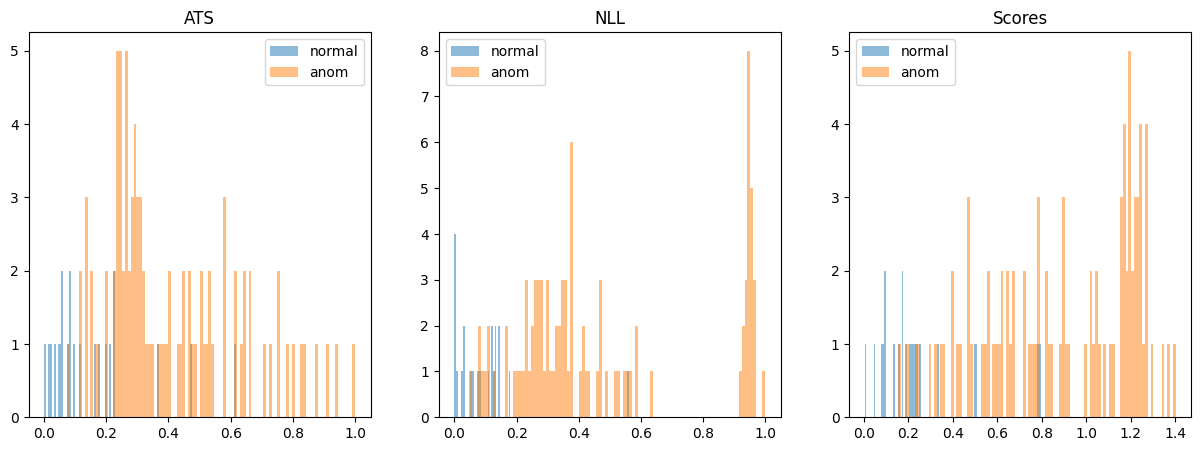

In [1321]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(normal_ats, bins=100, alpha=0.5, label="normal")
ax[0].hist(anomaly_ats, bins=100, alpha=0.5, label="anom")
ax[0].legend()
ax[0].set_title("ATS")

ax[1].hist(normal_nlls, bins=100, alpha=0.5, label="normal")
ax[1].hist(anomaly_nlls, bins=100, alpha=0.5, label="anom")
ax[1].legend()
ax[1].set_title("NLL")

ax[2].hist(normal_scores, bins=100, alpha=0.5, label="normal")
ax[2].hist(anomaly_scores, bins=100, alpha=0.5, label="anom")
ax[2].legend()
ax[2].set_title("Scores")

plt.show()

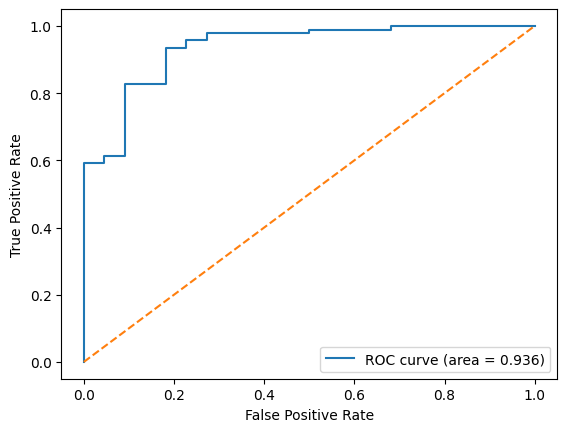

In [1317]:
# Calculate ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
y_true = np.concatenate([np.zeros(len(normal_scores)), np.ones(len(anomaly_scores))])
y_score = np.concatenate([normal_scores, anomaly_scores])

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = roc_auc_score(y_true, y_score)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.3f})")
ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
plt.show()

In [ ]:
# Combined different timescale scores
timesteps = [2, 3, 4]

normal_scores = np.zeros(len(normal_dataset))
anomaly_scores = np.zeros(len(anom_dataset))

for t in timesteps:
    model = init_denoiser(t, device, config, mim_in_sh, ckpt_path)
    normal_ats = []
    normal_nlls = []
    for batch in tqdm(normal_dataloader):
        images = batch["samples"].to(device)
        labels = batch["clslabels"].to(device)
        with torch.no_grad():
            latents_org, _ = feature_extractor(images)
            latents_org = (latents_org - avg_glo.view(1, -1, 1, 1)) / (std_glo.view(1, -1, 1, 1) + 1e-6)
            labels = None
            latents_last = model.ddim_reverse_sample(
                latents_org, start_t, labels, eta=0.0
            )
        latents_last_l2 = torch.sum(latents_last ** 2, dim=1).sqrt()
        ats = torch.abs(latents_last_l2 - torch.sqrt(torch.tensor([num_dims], device=device, dtype=torch.float32)))
        min_ats_spatial = ats.view(ats.shape[0], -1).min(dim=1)[0]
        max_ats_spatial = ats.view(ats.shape[0], -1).max(dim=1)[0]
        
        ats = torch.abs(min_ats_spatial - max_ats_spatial)
        nll = calculate_log_pdf(latents_last.cpu()) * -1
        normal_nlls.extend(nll)
        normal_ats.extend(ats.cpu().numpy())
    normal_ats = np.array(normal_ats)
    normal_nlls = np.array(normal_nlls)

    anomaly_ats = []
    anomaly_nlls = []
    for batch in tqdm(anom_dataloader):
        images = batch["samples"].to(device)
        labels = batch["clslabels"].to(device)
        with torch.no_grad():
            latents_org, _ = feature_extractor(images)
            latents_org = (latents_org - avg_glo.view(1, -1, 1, 1)) / (std_glo.view(1, -1, 1, 1) + 1e-6)
            labels = None
            latents_last = model.ddim_reverse_sample(
                latents_org, start_t, labels, eta=0.0
            )
        latents_last_l2 = torch.sum(latents_last ** 2, dim=1).sqrt()
        ats = torch.abs(latents_last_l2 - torch.sqrt(torch.tensor([num_dims], device=device, dtype=torch.float32)))
        min_ats_spatial = ats.view(ats.shape[0], -1).min(dim=1)[0]
        max_ats_spatial = ats.view(ats.shape[0], -1).max(dim=1)[0]
        ats = torch.abs(min_ats_spatial - max_ats_spatial)
        nll = calculate_log_pdf(latents_last.cpu()) * -1
        anomaly_nlls.extend(nll)
        anomaly_ats.extend(ats.cpu().numpy())
    
    anomaly_ats = np.array(anomaly_ats)
    anomaly_nlls = np.array(anomaly_nlls)

    ats_min = np.min([normal_ats.min(), anomaly_ats.min()])
    ats_max = np.max([normal_ats.max(), anomaly_ats.max()])
    nlls_min = np.min([normal_nlls.min(), anomaly_nlls.min()])
    nlls_max = np.max([normal_nlls.max(), anomaly_nlls.max()])
    
    normal_ats = (normal_ats - ats_min) / (ats_max - ats_min)
    normal_nlls = (normal_nlls - nlls_min) / (nlls_max - nlls_min)
    anomaly_ats = (anomaly_ats - ats_min) / (ats_max - ats_min)
    anomaly_nlls = (anomaly_nlls - nlls_min) / (nlls_max - nlls_min)
    
    normal_scores += normal_ats + normal_nlls
    anomaly_scores += anomaly_ats + anomaly_nlls

normal_scores /= len(timesteps)
anomaly_scores /= len(timesteps)

# Calculate ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
y_true = np.concatenate([np.zeros(len(normal_scores)), np.ones(len(anomaly_scores))])
y_score = np.concatenate([normal_scores, anomaly_scores])

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = roc_auc_score(y_true, y_score)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.3f})")
ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
plt.show()
        

 36%|███▌      | 5/14 [00:01<00:02,  3.26it/s]


KeyboardInterrupt: 

: 

### Masked Anomaly Score Prediction

In [ ]:
p = 0.5
p_ = torch.ones_like(latents_last) * p
masks = torch.bernoulli(p_)

latents_last_masked = latents_last * masks
latents_last_masked = latents_last_masked / p
latents_last_masked_l2 = torch.sum(latents_last_masked ** 2, dim=1).sqrt()  # (bs, h, w)

ats = torch.abs(latents_last_masked_l2 - torch.sqrt(torch.tensor([num_dims], device=device, dtype=torch.float32)))  # (bs, h, w)



torch.Size([7, 16, 16])

## ヤコビアン補正

In [34]:
def image_to_x0(image, feature_extractor, avg_glo, std_glo):
    with torch.no_grad():
        x, _ = feature_extractor(image)
        x = (x - avg_glo[None, :, None, None]) / (std_glo[None, :, None, None] + 1e-6)
    return x

def calculate_log_pdf(x):
    ll = -0.5 * (x ** 2 + np.log(2 * np.pi))
    ll = ll.sum(dim=(1, 2, 3))
    return ll

def ddim_step(x_t, t, labels, model):
    model_kwargs = dict(c=labels)
    sample_fn = model.net.forward
    out = model.sample_diffusion.ddim_reverse_sample(
        sample_fn,
        x_t,
        t,
        clip_denoised=False,
        model_kwargs=model_kwargs,
        eta=0.0
    )
    return out["sample"]

def compute_logdet_jacob(x_t, t, labels, model, num_samples=1):
    x_t = x_t.repeat(num_samples, 1, 1, 1)  # (N * num_samples, c, h, w)
    t = t.repeat(num_samples)  # (N * num_samples, )
    labels = labels.repeat(num_samples)  # (N * num_samples, )
    x_t.requires_grad_(True)
    model_kwargs = dict(c=labels)
    sample_fn = model.net.forward
    x_t_next = model.sample_diffusion.ddim_reverse_sample(
        sample_fn,
        x_t,
        t,
        clip_denoised=False,
        model_kwargs=model_kwargs,
        eta=0.0
    )["sample"]  # (N, c, h, w)
    x_t_next_unrepeated = x_t_next.view(num_samples, -1, *x_t_next.shape[1:])[0]  # (num_samples, c, h, w)
    
    # Hutchinson's trace estimator
    v = torch.randn_like(x_t)  # (N, c, h, w)
    
    z = torch.sum(x_t_next * v, dim=(1, 2, 3))  # (N * num_samples, )
    grad_z = torch.autograd.grad(z, x_t, torch.ones_like(z), create_graph=True)[0]  # (N * num_samples, c, h, w)
    trace_est_per_sample = torch.sum(grad_z * v, dim=(1, 2, 3))  # (N * num_samples, )
    trace_est_per_sample = trace_est_per_sample.view(num_samples, -1).mean(dim=0)  # (N, )
    trace_est = trace_est_per_sample
    return trace_est.detach(), x_t_next_unrepeated.detach()

In [855]:
num_total_steps = 2

denoiser = init_denoiser(num_total_steps, device, config, mim_in_sh, ckpt_path)
# batch = next(iter(train_loader))
# batch = next(iter(normal_dataloader))
batch = next(iter(anom_dataloader))
images = batch["samples"].to(device)
labels = batch["clslabels"].to(device)

In [856]:
start_t = torch.tensor([0] * bs, device=device, dtype=torch.long)
curernt_t = start_t
x_0 = image_to_x0(images, feature_extractor, avg_glo, std_glo)
trace_est, x_1 = compute_logdet_jacob(x_0, curernt_t, labels, denoiser, num_samples=4)

trace_est

NameError: name 'image_to_x0' is not defined

In [ ]:
indices = list(range(0, int(denoiser.num_sampling_steps)))
traces = []
x_t = x_0
for i in indices:
    t = torch.tensor([i] * x_0.shape[0]).to(x_0.device)
    trace_est, x_t = compute_logdet_jacob(x_t, t, labels, denoiser, num_samples=10)
    traces.append(trace_est)

trace_sum = torch.stack(traces, dim=0).sum(dim=0).cpu().numpy()  # (N, )
log_ll_last = calculate_log_pdf(x_t.cpu()).numpy()  # (N, )
log_ll = -1 * trace_sum + log_ll_last

print(f"Log-likelihood: {log_ll}")
print(f"Log likelihood last: {log_ll_last}")
print(f"Trace sum: {trace_sum}")


Log-likelihood: [-644859.   -672057.7  -651717.6  -664090.75 -657208.3  -645376.6
 -657340.1  -658619.75]
Log likelihood last: [-459843.1  -448832.66 -457716.88 -448302.7  -448900.22 -461626.28
 -448353.06 -446291.62]
Trace sum: [185015.88 223225.02 194000.75 215788.1  208308.1  183750.31 208987.05
 212328.11]


In [ ]:
normal_log_lls = []
for batch in tqdm(normal_dataloader):
    images = batch["samples"].to(device)
    labels = batch["clslabels"].to(device)
    
    x_0 = image_to_x0(images, feature_extractor, avg_glo, std_glo)
    indices = list(range(0, int(denoiser.num_sampling_steps)))
    traces = []
    x_t = x_0
    for i in indices:
        t = torch.tensor([i] * x_0.shape[0]).to(x_0.device)
        trace_est, x_t = compute_logdet_jacob(x_t, t, labels, denoiser, num_samples=10)
        traces.append(trace_est)

    trace_sum = torch.stack(traces, dim=0).sum(dim=0).cpu().numpy()  # (N, )
    log_ll_last = calculate_log_pdf(x_t.cpu()).numpy()  # (N, )
    log_ll = -1 * trace_sum + log_ll_last
    normal_log_lls.extend(log_ll)

anom_log_lls = []
for batch in tqdm(anom_dataloader):
    images = batch["samples"].to(device)
    labels = batch["clslabels"].to(device)
    
    x_0 = image_to_x0(images, feature_extractor, avg_glo, std_glo)
    indices = list(range(0, int(denoiser.num_sampling_steps)))
    traces = []
    x_t = x_0
    for i in indices:
        t = torch.tensor([i] * x_0.shape[0]).to(x_0.device)
        trace_est, x_t = compute_logdet_jacob(x_t, t, labels, denoiser, num_samples=10)
        traces.append(trace_est)

    trace_sum = torch.stack(traces, dim=0).sum(dim=0).cpu().numpy()  # (N, )
    log_ll_last = calculate_log_pdf(x_t.cpu()).numpy()  # (N, )
    log_ll = -1 * trace_sum + log_ll_last
    anom_log_lls.extend(log_ll)

100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


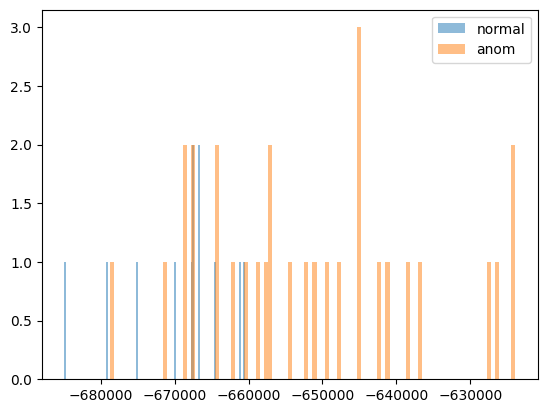

In [ ]:
# plot log-likelihoods
plt.hist(normal_log_lls, bins=100, alpha=0.5, label="normal")
plt.hist(anom_log_lls, bins=100, alpha=0.5, label="anom")
plt.legend()
plt.show()

In [689]:
normal_log_lls = np.array(normal_log_lls) * -1
anom_log_lls = np.array(anom_log_lls) * -1

y_true = np.concatenate([np.zeros(len(normal_log_lls)), np.ones(len(anom_log_lls))])
y_score = np.concatenate([normal_log_lls, anom_log_lls])
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = roc_auc_score(y_true, y_score)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.3f})")
ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()

plt.show()

NameError: name 'normal_log_lls' is not defined